# LSTM Price Forecasting – AAPL

This notebook uses an LSTM (Long Short-Term Memory) neural network to forecast AAPL stock prices based on historical closing prices.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM


In [2]:
ticker = "AAPL"
data = yf.download(ticker, start="2015-01-01", end="2023-12-31")[["Close"]].dropna()
data.columns = [ticker]
data.index = pd.to_datetime(data.index)
data = data.asfreq('B').dropna()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [3]:
scaler = MinMaxScaler()
scaled = scaler.fit_transform(data[[ticker]])

# Create sequences for LSTM
def create_sequences(data, seq_len):
    X, y = [], []
    for i in range(seq_len, len(data)):
        X.append(data[i-seq_len:i])
        y.append(data[i])
    return np.array(X), np.array(y)

seq_len = 60
X, y = create_sequences(scaled, seq_len)

# Train/test split
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [4]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    LSTM(50),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)


c:\Users\micha\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 55ms/step - loss: 0.0178
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 4.4422e-04
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 3.7105e-04
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step - loss: 3.9275e-04
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 3.4786e-04
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 3.8032e-04
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 3.5256e-04
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 4.5483e-04
Epoch 9/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 3.8938e-04
Epoch 10/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 3.3485e-04
Epoch 11/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 3.3143e-04
Epoch 12/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 3.2628e-04
Epoch 13/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 3.2726e-04
Epoch 14/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 2.6389e-04
Epoch 15/20
56/56 ━

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


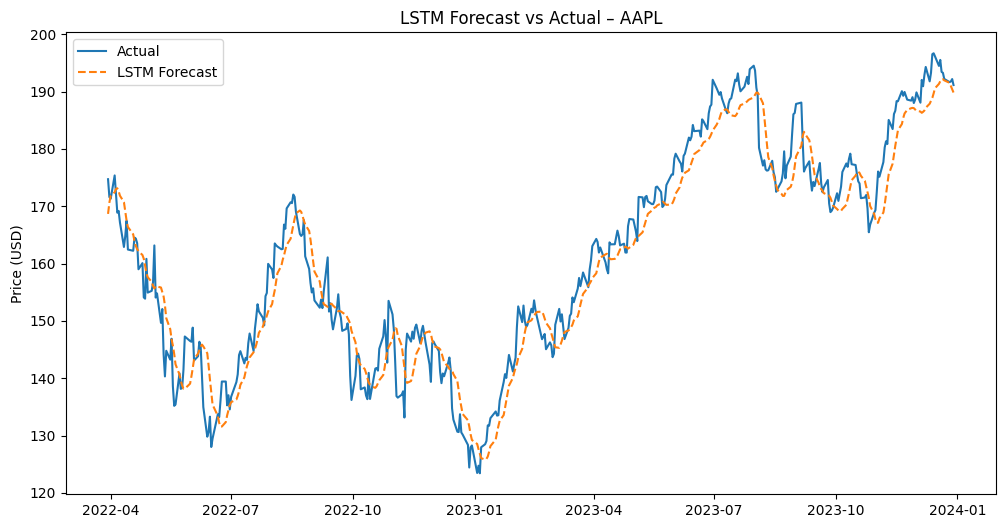

In [5]:
y_pred = model.predict(X_test)
y_pred_inv = scaler.inverse_transform(y_pred)
y_test_inv = scaler.inverse_transform(y_test)

dates = data.index[seq_len + split:]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inv, label='Actual')
plt.plot(dates, y_pred_inv, label='LSTM Forecast', linestyle='--')
plt.title("LSTM Forecast vs Actual – AAPL")
plt.ylabel("Price (USD)")
plt.legend()
plt.savefig("../output/aapl_lstm_forecast.png", dpi=300)
plt.show()


In [7]:
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)

mae = mean_absolute_error(y_test_inv, y_pred_inv)
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")


RMSE: 4.73
MAE: 3.90


In [8]:
# Create DataFrame for export
lstm_results = pd.DataFrame({
    'Date': dates,
    'Actual': y_test_inv.flatten(),
    'Forecast': y_pred_inv.flatten()
})

lstm_results.set_index('Date', inplace=True)

# Export to CSV
lstm_results.to_csv("../output/aapl_lstm_forecast.csv")
print("✅ LSTM forecast vs actual saved to: ../output/aapl_lstm_forecast.csv")


✅ LSTM forecast vs actual saved to: ../output/aapl_lstm_forecast.csv
